## Configuración Inicial

In [76]:
# IMPORTS
"""
Importación de librerías necesarias para procesamiento de lenguaje natural, 
visualización, entrenamiento de modelos de clasificación clásicos y embeddings contextuales.
Incluye compatibilidad con spaCy, BERT (BETO), NLPaug, y LLaMA vía Ollama.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Librerías Generales
import re
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
from tqdm import tqdm
import os
import joblib

# Librerías de Manejo de Datos y Visualización
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Librerías de Procesamiento de Lenguaje Natural
import nltk
import emoji
import spacy
from wordsegment import load, segment
import nlpaug.augmenter.word as naw
from nltk.corpus import wordnet as wn

# Librerías de Machine Learning
import tensorflow as tf
import torch
import torch.nn.functional as F
from transformers import TFBertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import issparse

# Ollama
from ollama import Client

In [28]:
# CONFIGURACION Y CARGA DE DATOS
"""
Carga del dataset, configuración de semilla aleatoria y preparación inicial del entorno NLP.
Incluye inicialización de etiquetado binario (LabelEncoder) y carga de modelos spaCy y WordSegment.
Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

random_state = 1
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')
nlp = spacy.load("es_core_news_sm")
load()

df = pd.read_csv("data.csv")
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['control', 'anorexia']) 
df['label_enc'] = label_encoder.transform(df['class'])
df.info()
df.describe()
df.head(5)

df_short = df.sample(frac=0.067, random_state=random_state).reset_index(drop=True) # Reducir el dataset a 100 filas

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     1500 non-null   object
 1   tweet_id    1500 non-null   object
 2   tweet_text  1500 non-null   object
 3   class       1500 non-null   object
 4   label_enc   1500 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 58.7+ KB


## Preprocesamientos
- Preprocesamiento BETO
- Preprocesamiento BoW
- Aumentador de datos

In [29]:
# PREPROCESAMIENTO BETO
"""
Transformación de textos usando embeddings contextuales de BETO (BERT entrenado en español).
Se aplican: demojización, tokenización, extracción del vector CLS y reducción dimensional con SVD.

Autor(es):
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def convert_emojis(text):
    '''
    Convierte emojis a texto usando la librería emoji.
    Se creó una función para evitar problemas al realizar las pruebas unitarias.
    '''
    return emoji.demojize(text)

def preprocess_text_bert(text):
    '''
    Preprocesamiento de texto para BETO:
    - Demojización
    - Tokenización
    - Extracción del vector CLS
    - Reducción dimensional con SVD
    '''
    text = convert_emojis(text)
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors='tf')
    model_output = model(encoded_input)
    embeddings = model_output.last_hidden_state[:, 0, :].numpy()
    return embeddings.flatten()

print("Procesando embeddings BETO...")
df['tweet_text_beto'] = df['tweet_text'].apply(preprocess_text_bert)
embeddings_matrix = np.stack(df['tweet_text_beto'].values)
embeddings_scaled = StandardScaler().fit_transform(embeddings_matrix)
svd = TruncatedSVD(n_components=500, random_state=random_state)
X_beto = svd.fit_transform(embeddings_scaled)
print("Embeddings BETO procesados.")

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Procesando embeddings BETO...
Embeddings BETO procesados.


In [30]:
# PREPROCESAMIENTO BAG OF WORDS (BoW)
"""
Pipeline clásico de procesamiento de texto: limpieza, lematización, segmentación de hashtags,
y extracción de características con Bag of Words (CountVectorizer con n-gramas).
Incluye cálculo de una métrica adicional: ratio de palabras en mayúsculas.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""


def split_hashtag(tag, verbose=False):
    '''
    Divide un hashtag en palabras separadas utilizando varias técnicas de segmentación.
    Esta función procesa hashtags y los convierte en frases legibles utilizando 
    dos métodos principales: detección de CamelCase y segmentación de palabras.
    - Primero elimina el símbolo '#' si existe
    - Intenta dividir por patrones CamelCase (mayúscula después de minúscula)
    - Si no hay patrones CamelCase, utiliza la biblioteca wordsegment para 
      identificar palabras dentro del texto concatenado
    - En caso de error durante la segmentación, devuelve el hashtag original en minúsculas
    '''
    tag = tag.lstrip('#')
    camel_split = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', tag).lower()
    if camel_split == tag.lower():
        try:
            segmented = segment(tag.lower())
            result = " ".join(segmented) if segmented else tag.lower()
            if verbose:
                print(f"Hashtag segmentado: #{tag} → {result}")
            return result
        except:
            if verbose:
                print(f"Error al segmentar hashtag: #{tag}. Se mantiene en minúsculas.")
            return tag.lower()
    if verbose:
        print(f"Hashtag segmentado por CamelCase: #{tag} → {camel_split}")
    return camel_split


def preprocess_text_bow(text, verbose=False):
    '''
    Esta función realiza múltiples operaciones de limpieza y normalización en un texto
    para prepararlo para análisis de lenguaje natural. El procesamiento incluye:
    conversión de emojis a texto, segmentación de hashtags, eliminación de URLs, 
    menciones, números, palabras vacías, y lematización de palabras.

    - Convierte emojis a texto descriptivo usando la función 'convert_emojis'
    - Divide hashtags en palabras separadas usando 'split_hashtag'
    - Elimina URLs, menciones (@usuario), y números
    - Elimina palabras vacías (stop words) y signos de puntuación
    - Lematiza las palabras restantes
    - Utiliza el pipeline de spaCy (objeto 'nlp') para procesamiento de lenguaje
    '''
    text = convert_emojis(text).lower()
    hashtags = re.findall(r"#\w+", text)
    for tag in hashtags:
        text = text.replace(tag, split_hashtag(tag, verbose=verbose))
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\d+", "", text)
    doc = nlp(text)
    lemmatized_words = [
        token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num
    ]
    cleaned = " ".join(lemmatized_words)
    if verbose:
        print(f"Texto lematizado: {cleaned[:50]}...")
    return cleaned


def calculate_uppercase_ratio(text, verbose=False):
    '''
    Calcula la proporción de palabras en mayúsculas en un texto dado.
    - Divide el texto en palabras usando el método split()
    - Filtra las palabras que están completamente en mayúsculas
    - Devuelve la proporción de palabras en mayúsculas respecto al total de palabras
    - Si no hay palabras, devuelve 0.0
    '''
    words = text.split()
    if not words:
        if verbose:
            print("Texto vacío, ratio de mayúsculas: 0.0")
        return 0.0
    uppercase_words = [w for w in words if w.isupper()]
    ratio = len(uppercase_words) / len(words)
    if verbose:
        print(f"Ratio de mayúsculas calculado: {ratio:.2f}")
    return ratio

print("Procesando texto para Bag of Words...")
# Aplicar preprocesamiento a los textos
df['uppercase_ratio'] = df['tweet_text'].apply(calculate_uppercase_ratio)
features = df['tweet_text'].apply(preprocess_text_bow)
df['cleaned_tweet'] = features

# Bag of Words con CountVectorizer, incluyendo unigramas y bigramas.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_bow = vectorizer.fit_transform(df['cleaned_tweet'])

y = df['label_enc'].values

print("Preprocesamiento de Bag of Words completado.")

Procesando texto para Bag of Words...
Preprocesamiento de Bag of Words completado.


In [ ]:
# AUGMENTADOR 
"""
Aplicación de técnicas de aumentación textual para la rama BoW.
Se pueden aplicar sustituciones contextuales con BERT o técnicas clásicas como sinónimos (WordNet) e intercambio de palabras.
El usuario puede activar aumentación con AUGMENT_DATA = True y guardar el nuevo dataset extendido.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""

import nltk
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')
nltk.download('wordnet')

AUGMENT_DATA = False
augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-uncased',
    model_type='bert',
    action="substitute",
    device='cpu'
)

def generate_augmented_bow_data(X_texts, y_labels, augment_factor=1):
    '''
    Genera datos aumentados para el modelo BoW utilizando un factor de aumentación.
    - X_texts: lista de textos originales
    - y_labels: lista de etiquetas originales
    - augment_factor: número de veces que se desea aumentar cada texto
    - Devuelve listas de textos y etiquetas aumentadas
    '''

    aug_texts, aug_labels = [], []
    for i, text in enumerate(X_texts):
        for _ in range(augment_factor):
            try:
                aug = augmenter.augment(text)
            except:
                aug = text
            aug_texts.append(aug)
            aug_labels.append(y_labels[i])
    return aug_texts, aug_labels

# Reemplazo de SynonymAug con función personalizada para español
def get_spanish_synonyms(word):
    """
    Obtiene sinónimos en español para una palabra dada utilizando WordNet.

    Returns
    -------
    list[str]
        Lista (única) de sinónimos en español.  
        • Se eliminan duplicados.  
        • No se incluye la palabra original (`word`) en la salida.  
        • Los guiones bajos de WordNet se sustituyen por espacios.

    """
    synonyms = set()
    for synset in wn.synsets(word, lang='spa'):
        for lemma in synset.lemmas('spa'):
            synonym = lemma.name().replace("_", " ")
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

class SpanishSynonymAug:
    """
    Aumentador de datos basado en la sustitución de sinónimos (WordNet-ES).
    Este *augmenter* selecciona aleatoriamente un subconjunto de palabras de
    un texto y las reemplaza por sinónimos en español obtenidos con
    `get_spanish_synonyms`.
    Parámetros
    ----------
    aug_p : float, opcional (default=0.3)
        Proporción de palabras susceptibles de ser reemplazadas.  
        Se garantiza que al menos una palabra sea candidata.

    Métodos
    -------
    augment(text)
        Devuelve una nueva versión del `text` con palabras sustituidas por
        sinónimos.
    """
    def __init__(self, aug_p=0.3):
        self.aug_p = aug_p

    def augment(self, text):
        """
        Genera una versión aumentada del texto mediante sinónimos.

        Returns
        -------
        str
            Texto con cero o más palabras reemplazadas por sinónimos.
        """
        words = text.split()
        new_words = words.copy()
        num_to_aug = max(1, int(len(words) * self.aug_p))
        indices = list(range(len(words)))
        random.shuffle(indices)

        for idx in indices:
            word = words[idx]
            synonyms = get_spanish_synonyms(word)
            if synonyms:
                new_words[idx] = random.choice(synonyms)
                num_to_aug -= 1
            if num_to_aug <= 0:
                break
        return " ".join(new_words)

# Reemplazo de syn_aug con versión funcional
syn_aug = SpanishSynonymAug(aug_p=0.3)
swap_aug = naw.RandomWordAug(action="swap", aug_p=0.2)

def augment_text_complex(text, num_augments=1):
    '''
    Genera múltiples versiones aumentadas de un texto utilizando sinónimos y permutaciones.
    - text: texto original a aumentar
    - num_augments: número de versiones aumentadas a generar
    - Devuelve una lista de textos aumentados
    '''
    augmented_texts = []
    for _ in range(num_augments):
        aug_type = random.choice(['synonym', 'swap'])
        if aug_type == 'synonym':
            augmented = syn_aug.augment(text)
        elif aug_type == 'swap':
            augmented = swap_aug.augment(text)
        else:
            augmented = text
        if isinstance(augmented, list):
            augmented = augmented[0]
        augmented_texts.append(augmented)
    return augmented_texts

original_texts = list(df['cleaned_tweet'])
original_labels = list(y)

# Si se elige aumentar los datos, se generan versiones aumentadas de los textos originales
if AUGMENT_DATA:
    print("Generando datos aumentados para BoW...")
    augmented_texts = []
    augmented_labels = []

    for text, label in zip(original_texts, original_labels):
        augmented_versions = augment_text_complex(text, num_augments=2)
        augmented_texts.extend(augmented_versions)
        augmented_labels.extend([label] * len(augmented_versions))

    # Dataset extendido: original + aumentados
    combined_texts = list(df['cleaned_tweet']) + augmented_texts
    combined_labels = list(y) + augmented_labels

    # Guardar dataset
    df_aug = pd.DataFrame({
        'tweet_text': combined_texts,
        'label_enc': combined_labels
    })
    df_aug.to_csv("augmented_data.csv", index=False)
    print("Datos aumentados guardados como 'augmented_data.csv'.")

else:
    print("AUGMENT_DATA = False — Usando solo los datos originales.")
    combined_texts = original_texts
    combined_labels = original_labels

vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_aug_bow = vectorizer.fit_transform(combined_texts)
y_aug_bow = np.array(combined_labels)
print("Datos aumentados para BoW procesados.")

AUGMENT_DATA = False — Usando solo los datos originales.
Datos aumentados para BoW procesados.


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Funciones de Clasificación

- Funciones de Evaluación (BETO, BoW)
- Funciones de Evaluación (LLM)
- Definición de hiperparámetros para GridSearch


In [ ]:
# FUNCIONES DE EVALUACION CON CV (BoW, BETO)
"""
Define funciones auxiliares para evaluar modelos con validación cruzada:
- Matriz de confusión
- Curva ROC
- Curva de aprendizaje
También guarda los mejores modelos y registra métricas en un diccionario global `results_list`.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

results_list = []

def plot_confusion_matrix_cv(y_true, y_pred, labels, model_name, pipeline_name, ax):
    '''
    Plot de la matriz de confusión utilizando seaborn.
    - y_true: etiquetas verdaderas
    - y_pred: etiquetas predichas
    - labels: etiquetas de clase
    - model_name: nombre del modelo
    - pipeline_name: nombre del pipeline
    - ax: objeto Axes para el plot
    '''
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

def plot_roc_curve_cv(model, X, y, cv, ax):
    '''
    Plot de la curva ROC utilizando validación cruzada.
    - model: modelo entrenado
    - X: características de entrada
    - y: etiquetas de clase
    - cv: número de pliegues para la validación cruzada
    - ax: objeto Axes para el plot
    '''
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        model.fit(X[train_idx], y[train_idx])
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X[test_idx])[:,1]
        else:
            y_score = model.decision_function(X[test_idx])
        y_test_bin = label_binarize(y[test_idx], classes=np.unique(y)).ravel()
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        auc = roc_auc_score(y_test_bin, y_score)
        ax.plot(fpr, tpr, label=f"Fold {i+1} (AUC={auc:.2f})")
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_title("ROC Curve")
    ax.set_xlabel("Falsos Positivos")
    ax.set_ylabel("Verdaderos Positivos")
    ax.grid(True)
    ax.legend(fontsize='small')

def plot_learning_curve_cv(model, X, y, cv, ax):
    '''
    Plot de la curva de aprendizaje utilizando validación cruzada.
    - model: modelo entrenado
    - X: características de entrada
    - y: etiquetas de clase
    - cv: número de pliegues para la validación cruzada
    - ax: objeto Axes para el plot
    '''
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv, scoring='f1_weighted', n_jobs=-1
    )
    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    val_mean, val_std = np.mean(val_scores, axis=1), np.std(val_scores, axis=1)

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    ax.plot(train_sizes, train_mean, 'o--', color='blue', label='Train Mean')
    ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Val Mean')

    ax.set_title("Learning Curve")
    ax.set_xlabel("Muestras de entrenamiento")
    ax.set_ylabel("F1 Score")
    ax.grid(True)
    ax.legend(fontsize='small')

def evaluate_model_cv(model, param_grid, X, y, model_name, pipeline_name, cv=5, save_dir="saved_models"):
    """
    Realiza búsqueda de hiperparámetros con GridSearchCV y evaluación con CV:
    - Ajusta modelo y predice con cross_val_predict.
    - Guarda el mejor modelo a disco.
    - Muestra métricas, matriz de confusión, ROC y curva de aprendizaje.
    - Almacena resultados en `results_list`.
    """
    print(f"\nEvaluando {model_name} en {pipeline_name} con KFold CV...")

    os.makedirs(save_dir, exist_ok=True)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid = GridSearchCV(model, param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    
    # Guardar modelo
    model_filename = f"{save_dir}/{pipeline_name}_{model_name.replace(' ', '_')}.joblib"
    joblib.dump(best_model, model_filename)
    print(f"Modelo guardado como {model_filename}")
    
    y_pred = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)
    y_prob = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1, method='predict_proba')[:, 1]

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted')
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_prob)

    # Subplots: 1 row x 3 cols
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{model_name} - {pipeline_name}", fontsize=14)

    plot_confusion_matrix_cv(y, y_pred, labels=np.unique(y), model_name=model_name, pipeline_name=pipeline_name, ax=axs[0])
    if len(np.unique(y)) == 2:
        plot_roc_curve_cv(best_model, X, y, cv, ax=axs[1])
    else:
        axs[1].axis('off')  # ROC not applicable
    plot_learning_curve_cv(best_model, X, y, cv, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    results_list.append({
        'Pipeline': pipeline_name,
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc,
        'Best Params': grid.best_params_
    })
    

In [ ]:
# FUNCIONES DE EVALUACION CON CV (OLLAMA)
base_prompt = (
    "Eres un modelo entrenado para análisis lingüístico con fines académicos. "
    "Debes evaluar si un tweet contiene lenguaje asociado a conductas relacionadas con la anorexia, "
    "Evalúa solamente el contenido textual del tweet.\n\n"
    "Responde con un número entre 0.0 (ausencia total) y 1.0 (presencia explícita) según la presencia de:\n"
    "- Restricción alimentarias\n"
    "- Mención de malestar físico o emocional vinculado con la comida o el cuerpo\n"
    "- Comentarios autocríticos o negativos hacia uno mismo\n"
    "- Control del peso\n"
    "- Enfoque en apariencia corporal o metas de peso estrictas\n"
    "- Uso de expresiones sobre sentirse liviano, vacío o necesidad de control\n\n"
    "Ejemplo de respuesta válida: 0.83\n"
    "No expliques tu razonamiento ni incluyas advertencias. Devuelve únicamente el número decimal."
)

def classify_with_ollama_model_contextual(
    df, model_name, prob_column_name=None, csv_cache_path=None,
    max_workers=4, k_context_reset=5
):
    """
    Clasifica cada tweet de un DataFrame usando un modelo de Ollama con
    *prompt* contextual y multihilo.
    El modelo devuelve una probabilidad (0.0–1.0) de que el tweet contenga
    lenguaje asociado a la anorexia.  
    Las predicciones se almacenan en una nueva columna del `df` y, de forma
    opcional, se cachean en disco para evitar consultas repetidas.

    Returns
    -------
    pandas.DataFrame
        El mismo DataFrame de entrada con la columna de probabilidades añadida.
    Errores
    -------
    - Si la inferencia falla para un tweet, se asigna ``-1.0`` como valor
      sentinela y se muestra un mensaje de error.
    """
    # Generar nombres predeterminados si no se proporcionan
    safe_model_id = model_name.replace(':', '_').replace('-', '_')
    if prob_column_name is None:
        prob_column_name = f"{safe_model_id}_prob"
        print(f"⚠️ No se proporcionó un nombre de columna. Usando: '{prob_column_name}'.")

    if csv_cache_path is None:
        csv_cache_path = f"{prob_column_name}_predictions.csv"
        print(f"⚠️ No se proporcionó una ruta de caché. Usando: '{csv_cache_path}'.")

    client = Client(host='http://localhost:11434')

    def classify_batch_contextual(texts, progress_bar, lock):
        """
        Clasifica un lote (batch) de textos manteniendo un contexto conversacional.
        Cada batch reutiliza un único historial de mensajes (`messages`) que
        comienza con el `base_prompt` (rol «system») y se va ampliando con pares
        pregunta-respuesta.  
        El historial se reinicia cuando alcanza `k_context_reset` interacciones
        para evitar que la ventana de contexto del modelo se desborde.

        Returns
        -------
        list[float]
            Probabilidades (0.0–1.0) devueltas por el modelo para cada tweet en
            el mismo orden de `texts`.  
            Si la llamada a Ollama falla se devuelve «-1.0» como valor sentinela.
        """
        results = []
        messages = [{"role": "system", "content": base_prompt}]
        context_count = 0

        for text in texts:
            messages.append({"role": "user", "content": f"Tweet: '{text}'\nProbabilidad:"})

            try:
                response = client.chat(model=model_name, messages=messages)
                reply = response['message']['content'].strip()
                match = re.search(r"\b([01](?:\.\d+)?)\b", reply)
                prob = float(match.group(1)) if match else -1.0
            except Exception as e:
                print(f"❌ Error en inferencia: {e}")
                prob = -1.0

            results.append(prob)

            # Agregar respuesta del modelo para mantener el contexto
            messages.append({"role": "assistant", "content": str(prob)})
            context_count += 1

            # Reiniciar el contexto cada k elementos
            if context_count >= k_context_reset:
                messages = [{"role": "system", "content": base_prompt}]
                context_count = 0

            # Actualizar el progreso por tweet
            with lock:
                progress_bar.update(1)

        return results

    def classify_all_multithread(texts):
        """
        Lanza varios hilos para ejecutar `classify_batch_contextual` en paralelo.
        El conjunto completo se divide en bloques de aproximadamente el mismo
        tamaño; cada hilo procesa un bloque independiente y escribe los resultados
        en la lista `results` preservando el orden original.

        Returns
        -------
        list[float]
            Vector de probabilidades con la misma longitud y orden que `texts`.
        """
        results = [None] * len(texts)
        chunk_size = (len(texts) + max_workers - 1) // max_workers
        chunks = [(i, texts[i:i + chunk_size]) for i in range(0, len(texts), chunk_size)]

        progress_bar = tqdm(total=len(texts), desc=f"Clasificando con {model_name}", dynamic_ncols=True)
        lock = Lock()

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(classify_batch_contextual, chunk, progress_bar, lock): start_idx
                for start_idx, chunk in chunks
            }

            for future in as_completed(futures):
                idx_start = futures[future]
                try:
                    chunk_results = future.result()
                    results[idx_start:idx_start + len(chunk_results)] = chunk_results
                except Exception as e:
                    print(f"❌ Error inesperado: {e}")
                    results[idx_start:idx_start + chunk_size] = [-1.0] * chunk_size

        progress_bar.close()
        return results

    # Verifica si existe el archivo cacheado
    if os.path.exists(csv_cache_path):
        print(f"📂 Archivo encontrado: {csv_cache_path}. Cargando predicciones...")
        df_pred = pd.read_csv(csv_cache_path)
        df[prob_column_name] = df_pred[prob_column_name]
    else:
        df[prob_column_name] = classify_all_multithread(df['tweet_text'].tolist())
        df[['tweet_id', prob_column_name]].to_csv(csv_cache_path, index=False)
        print(f"✅ Predicciones guardadas en {csv_cache_path}.")

    return df

def grid_search_k_reset(
    df, model_name, true_labels, k_values,
    prob_column_prefix=None, cache_dir=".",
    max_workers=4, scoring_fn=roc_auc_score, verbose=True
):
    """
    Búsqueda exhaustiva del hiperparámetro *k_context_reset* para LLM-Ollama.
    Para cada valor de `k_values` se:
    1. Generan/recuperan las predicciones con
       `classify_with_ollama_model_contextual`.
    2. Se calcula la métrica indicada por `scoring_fn` (AUC por defecto).
    3. Se guarda el par (k, score).


    Returns
    -------
    tuple
        ``(best_k, scores)`` donde  
        • `best_k` es el valor de k con mayor *score*.  
        • `scores`  es una lista de tuplas ``(k, score)`` orden cronológico.
    """
    # Construir prefijo seguro
    safe_model_id = model_name.replace(':', '_').replace('-', '_')
    if prob_column_prefix is None:
        prob_column_prefix = f"{safe_model_id}_prob"

    scores = []

    for k in k_values:
        print(f"\n🔍 Probando k = {k}...")

        prob_column_name = f"{prob_column_prefix}_k{k}"
        csv_cache_path = os.path.join(cache_dir, f"{prob_column_name}.csv")

        df_copy = df.copy()
        df_copy = classify_with_ollama_model_contextual(
            df_copy,
            model_name=model_name,
            prob_column_name=prob_column_name,
            csv_cache_path=csv_cache_path,
            max_workers=max_workers,
            k_context_reset=k
        )

        y_prob = df_copy[prob_column_name].values
        y_true = true_labels

        # Filtrar predicciones inválidas
        valid_mask = y_prob != -1.0
        y_prob_valid = y_prob[valid_mask]
        y_true_valid = np.array(y_true)[valid_mask]

        if len(np.unique(y_true_valid)) < 2:
            score = 0.0
            if verbose:
                print(f"⚠️ No hay clases suficientes en y_true válido (k={k}), score=0.0")
        else:
            try:
                score = scoring_fn(y_true_valid, y_prob_valid)
            except Exception as e:
                print(f"❌ Error calculando métrica para k={k}: {e}")
                score = 0.0

        scores.append((k, score))
        print(f"k={k}, {scoring_fn.__name__} = {score:.4f}")

    best_k, best_score = max(scores, key=lambda x: x[1])
    print(f"\n🏆 Mejor valor de k: {best_k} con {scoring_fn.__name__} = {best_score:.4f}")

    return best_k, scores

def process_llm_broken_predictions(df_pred, prob_col, process_broken_prompt=-1):
    """
    Limpia o repara predicciones fallidas (valor «-1.0») provenientes de un LLM.
    Parámetros
    ----------
    df_pred : pandas.DataFrame
        DataFrame que contiene la columna de probabilidades.
    prob_col : str
        Nombre de la columna con las probabilidades del modelo.
    process_broken_prompt : {-1, 0, 1}, opcional (default=-1)
        Estrategia para manejar los valores «-1.0».  
        - ``-1`` : eliminar filas con «-1.0» (ignorarlas).  
        - ``0``  : reemplazar por 0.0.  
        - ``1``  : reemplazar por 1.0.
    Returns
    -------
    tuple
        ``(y_true, y_prob)`` listos para su uso en métricas:
        - `y_true` → ``numpy.ndarray`` de etiquetas verdaderas.  
        - `y_prob` → ``numpy.ndarray`` de probabilidades después del post-proceso.
    Raises
    ------
    ValueError
        Si `process_broken_prompt` no está en {-1, 0, 1}.
    """
    if process_broken_prompt == -1:
        valid_mask = df_pred[prob_col] != -1.0
        y_true = df_pred.loc[valid_mask, "label_enc"].values
        y_prob = df_pred.loc[valid_mask, prob_col].values
    elif process_broken_prompt in [0, 1]:
        y_true = df_pred["label_enc"].values
        y_prob = df_pred[prob_col].replace(-1.0, float(process_broken_prompt)).values
    else:
        raise ValueError(f"Valor no válido para process_broken_prompt: {process_broken_prompt}")
    return y_true, y_prob


In [34]:
# PARÁMETROS DE GRIDSEARCH
"""
Define los espacios de búsqueda de hiperparámetros para los clasificadores:
- Logistic Regression
- Random Forest
- Support Vector Machines
- LLM k context reset
Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

param_grid_lr = {
    'C': [0.01, 0.1, 0.5, 1, 5],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 500]
}
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}
param_grid_svm = [
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'shrinking': [True]
    },
    {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'shrinking': [True]
    }
]

k_range = [1, 3, 5, 10, 20, 25, 30, 50]

## Modelos de Clasificación
- **BETO**  
  Modelo basado en BERT entrenado específicamente para el español.

- **BoW (Bag of Words)**  
  Enfoque clásico de representación textual utilizando n-gramas con CountVectorizer.

- **LLMs:**
  - **Gemma 3 (`gemma3:27b`)**  
    Modelo ligero desarrollado por Google basado en la arquitectura Gemini. Lanzado en febrero de 2024.
  
  - **LLaMA 3.1 (`llama3.1:8b`)**  
    Tercera generación de modelos desarrollados por Meta. Primer modelo abierto en competir con los líderes del sector en múltiples métricas. Lanzado en abril de 2024.


### Modelos de Clasificación | BETO



=== Evaluando modelos en pipeline: BETO ===

Evaluando Logistic Regression en BETO con KFold CV...
Modelo guardado como saved_models/BETO_Logistic_Regression.joblib


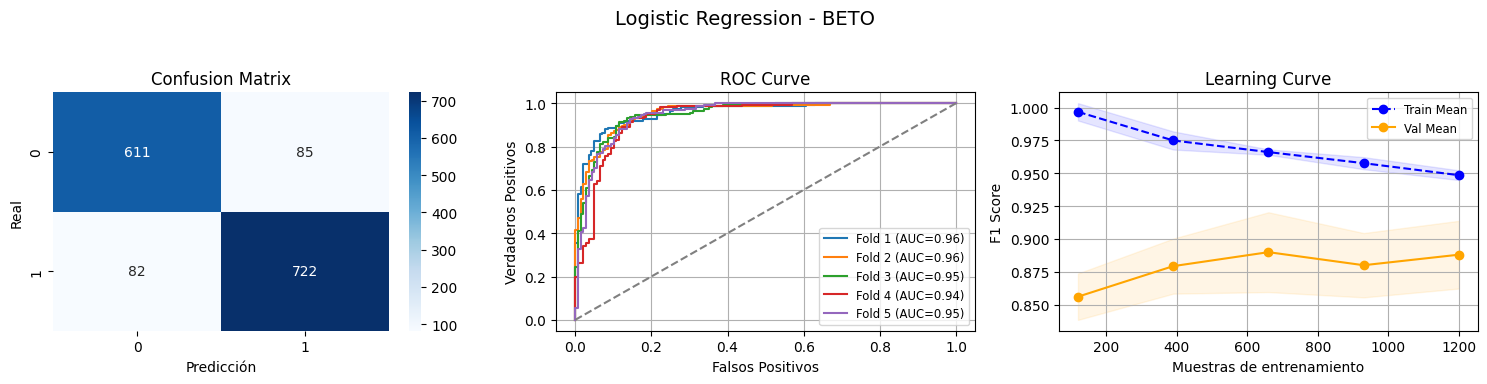


Evaluando Random Forest en BETO con KFold CV...
Modelo guardado como saved_models/BETO_Random_Forest.joblib


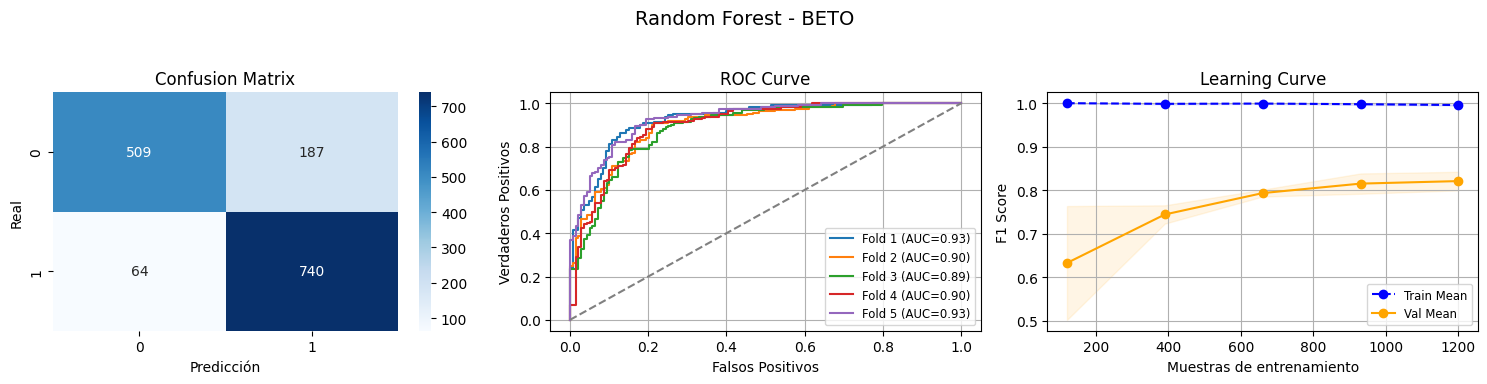


Evaluando SVM en BETO con KFold CV...
Modelo guardado como saved_models/BETO_SVM.joblib


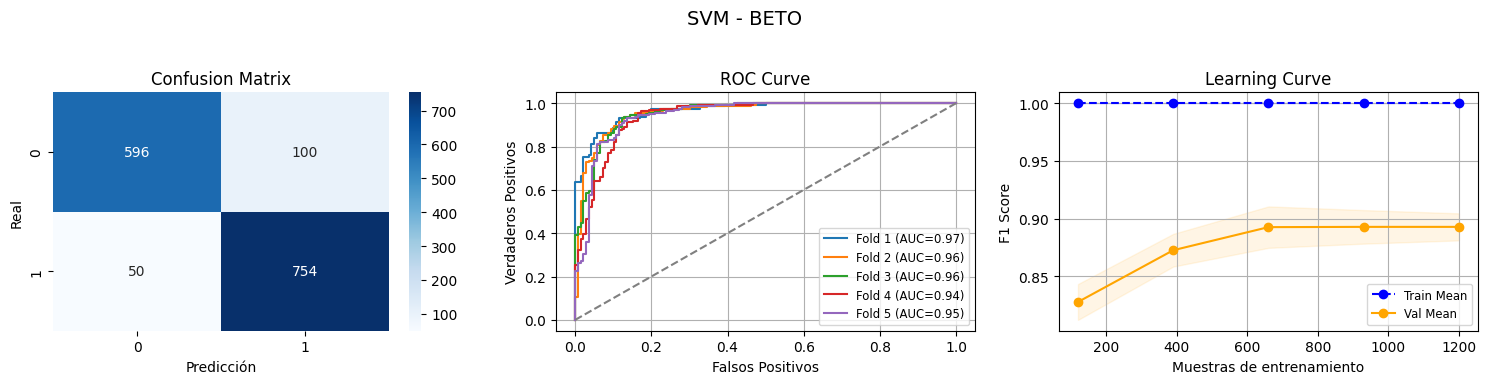

In [ ]:
# EVALUACIÓN DEL MODELO BETO
"""
Evalúa múltiples clasificadores clásicos sobre los embeddings generados por BETO:
- Logistic Regression
- Random Forest
- SVM
Se aplican validación cruzada, búsqueda de hiperparámetros, y visualización de resultados.

Autor(es):
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
"""

print("\n=== Evaluando modelos en pipeline: BETO ===")
X_beto_input = X_beto if not issparse(X_beto) else X_beto.tocsr()
for clf, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic_Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random_Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(clf, param_grid, X_beto_input, y, name, "BETO")


## Modelos de Clasificación | BoW


=== Evaluando modelos en pipeline: BoW ===

Evaluando Logistic Regression en BoW con KFold CV...
Modelo guardado como saved_models/BoW_Logistic_Regression.joblib


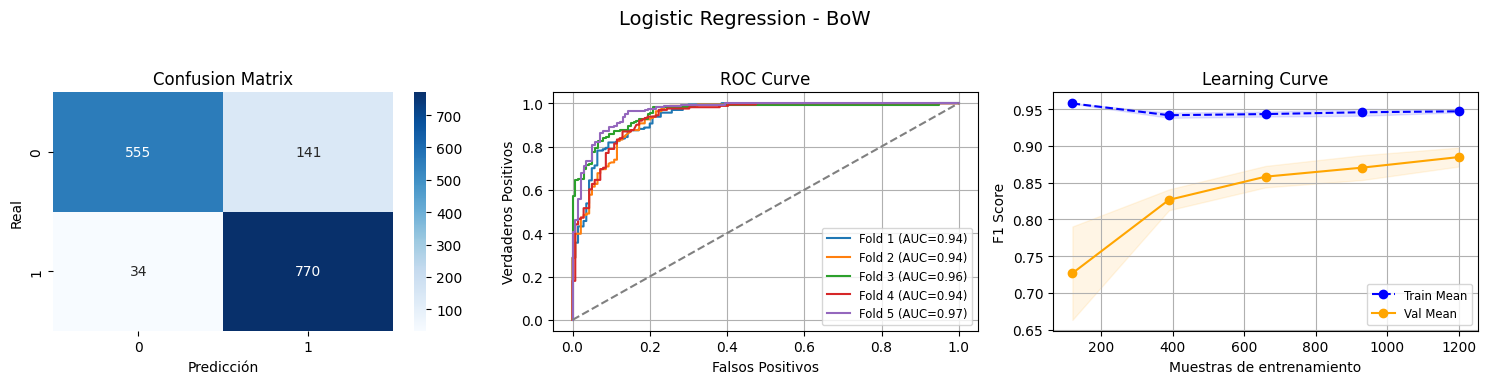


Evaluando Random Forest en BoW con KFold CV...
Modelo guardado como saved_models/BoW_Random_Forest.joblib


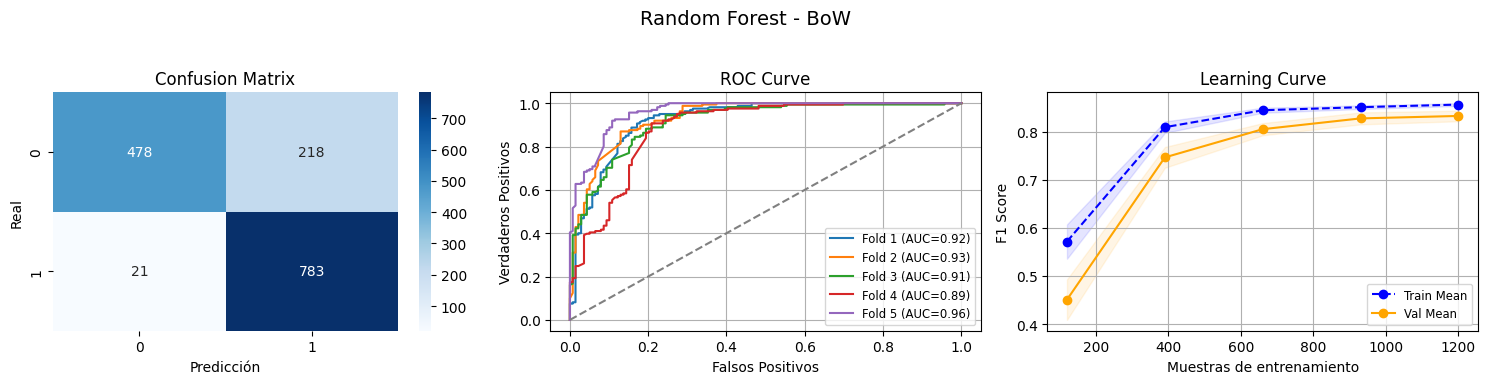


Evaluando SVM en BoW con KFold CV...
Modelo guardado como saved_models/BoW_SVM.joblib


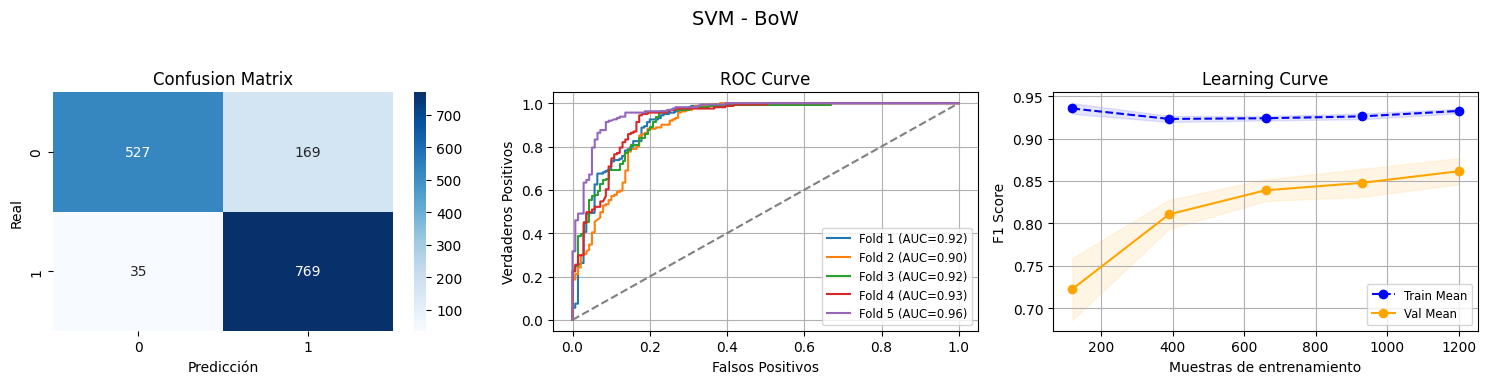

In [ ]:
# EVALUACIÓN DEL MODELO BoW
"""
Evalúa clasificadores clásicos sobre las representaciones Bag-of-Words (originales o aumentadas).
Incluye exactamente el mismo conjunto de modelos y proceso que BETO.
Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""

print("\n=== Evaluando modelos en pipeline: BoW ===")
X_bow_input = X_aug_bow if not issparse(X_aug_bow) else X_aug_bow.tocsr()
for clf, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic_Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random_Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(clf, param_grid, X_bow_input, y_aug_bow, name, "BoW")

## Modelos de Clasificación | LLMs

In [37]:
# EVALUACIÓN DE LLMs CON OLLAMA
"""
Evalúa un modelo de lenguaje (LLM) utilizando Ollama para clasificar tweets.
Se utiliza un modelo de LLM para clasificar tweets en función de patrones asociados con anorexia.
Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

'\nEvalúa un modelo de lenguaje (LLM) utilizando Ollama para clasificar tweets.\nSe utiliza un modelo de LLM para clasificar tweets en función de patrones asociados con anorexia.\nAutor(es):\n    - Aldehil de Jesús Sánchez Hernández A01748442\n    - Gustavo Téllez Mireles A01747114\n    - Jorge Iván Rodríguez Reyes A01747131\n    - Eduardo Francisco Lugo Quintana A01747490\n'

### Gemma3:27b

In [38]:
# BUSQUEDA DE RESET CONTEXT K IDEAL PARA GEMMA3
gemma3_27b_best_k, gemma3_27b_k_scores = grid_search_k_reset(
    df=df_short,
    model_name="gemma3:27b",
    true_labels=df_short['label_enc'].values,
    k_values=k_range,
    prob_column_prefix="gemma3_27b", # Prefix for the probability column name (e.g., 'gemma7b_prob_k5')
    cache_dir="./LLM_files", # Directory to save cached predictions
    scoring_fn=roc_auc_score,
    max_workers=12
)
print(f"Mejor k para gemma3_27b: {gemma3_27b_best_k}")
print("Scores para gemma3_27b:", gemma3_27b_k_scores)


🔍 Probando k = 1...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k1.csv. Cargando predicciones...
k=1, roc_auc_score = 0.9128

🔍 Probando k = 3...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k3.csv. Cargando predicciones...
k=3, roc_auc_score = 0.9068

🔍 Probando k = 5...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k5.csv. Cargando predicciones...
k=5, roc_auc_score = 0.9008

🔍 Probando k = 10...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k10.csv. Cargando predicciones...
k=10, roc_auc_score = 0.9084

🔍 Probando k = 20...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k20.csv. Cargando predicciones...
k=20, roc_auc_score = 0.9202

🔍 Probando k = 25...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k25.csv. Cargando predicciones...
k=25, roc_auc_score = 0.9200

🔍 Probando k = 30...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k30.csv. Cargando predicciones...
k=30, roc_auc_score = 0.9232

🔍 Probando k = 50...
📂 Archivo encontrado: ./LLM_files\gemma3_27b_k50.csv. Cargando predicciones..

In [39]:
# CLASIFICACION CON EL MODELO GEMMA3
df_gemma3_27b_predictions = classify_with_ollama_model_contextual(
    df=df,
    model_name="gemma3:27b",
    prob_column_name="gemma3_27b_prob_k20",
    csv_cache_path=f"./LLM_files/gemma3_27b_predictions_k30.csv",
    max_workers=12,
    k_context_reset=gemma3_27b_best_k,
)

📂 Archivo encontrado: ./LLM_files/gemma3_27b_predictions_k30.csv. Cargando predicciones...


In [40]:
# PROCESAR PREDICCIONES NO VALIDAS
# -1 Ignorar
# 0 Reemplazar por 0.0
# 1 Reemplazar por 1.0
y_true, y_prob = process_llm_broken_predictions(
    df_pred=df_gemma3_27b_predictions,
    prob_col="gemma3_27b_prob_k20", 
    process_broken_prompt=1
)

In [41]:
# GENERAR PREDICCION BINARIA Y GUARDAR RESULTADOS
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)

# Guardar resultados
results_list.append({
    'Pipeline': "OLLAMA",
    'Model': "gemma3:27b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc,
    'Best Params': {'k_context_reset': gemma3_27b_best_k}
})

### LLaMA3.1:8b

In [42]:
# BUSQUEDA DE RESET CONTEXT K IDEAL PARA LLAMA3
llama3_1_8b_best_k, llama3_1_8b_k_scores = grid_search_k_reset(
    df=df_short,
    model_name="llama3.1:8b",
    true_labels=df_short['label_enc'].values,
    k_values=k_range,
    prob_column_prefix="llama3_1_8b", # Prefix for the probability column name
    cache_dir="./LLM_files", # Directory to save cached predictions
    scoring_fn=roc_auc_score,
    max_workers=12
)
print(f"Mejor k para llama3_1_8b: {llama3_1_8b_best_k}")
print("Scores para llama3_1_8b:", llama3_1_8b_k_scores)


🔍 Probando k = 1...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k1.csv. Cargando predicciones...
k=1, roc_auc_score = 0.8740

🔍 Probando k = 3...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k3.csv. Cargando predicciones...
k=3, roc_auc_score = 0.8631

🔍 Probando k = 5...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k5.csv. Cargando predicciones...
k=5, roc_auc_score = 0.9012

🔍 Probando k = 10...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k10.csv. Cargando predicciones...
k=10, roc_auc_score = 0.9152

🔍 Probando k = 20...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k20.csv. Cargando predicciones...
k=20, roc_auc_score = 0.8898

🔍 Probando k = 25...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k25.csv. Cargando predicciones...
k=25, roc_auc_score = 0.9038

🔍 Probando k = 30...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k30.csv. Cargando predicciones...
k=30, roc_auc_score = 0.9177

🔍 Probando k = 50...
📂 Archivo encontrado: ./LLM_files\llama3_1_8b_k50.csv. Cargando predic

In [43]:
# CLASIFICACION CON EL MODELO LLAMA3
df_llama3_1_8b_predictions = classify_with_ollama_model_contextual(
    df=df,
    model_name="llama3.1:8b",
    prob_column_name="llama3_1_8b_prob_k30",
    csv_cache_path="./LLM_files/llama3_1_8b_predictions_k30.csv",
    max_workers=12,
    k_context_reset=llama3_1_8b_best_k,
)

📂 Archivo encontrado: ./LLM_files/llama3_1_8b_predictions_k30.csv. Cargando predicciones...


In [44]:
# PROCESAR PREDICCIONES NO VALIDAS
y_true, y_prob = process_llm_broken_predictions(
    df_llama3_1_8b_predictions, 
    "llama3_1_8b_prob_k30", 
    process_broken_prompt=1
)

In [45]:
# GENERAR PREDICCION BINARIA Y GUARDAR RESULTADOS
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)
# Guardar resultados
results_list.append({
    'Pipeline': "OLLAMA",
    'Model': "llama3.1:8b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc,
    'Best Params': {'k_context_reset': llama3_1_8b_best_k}
})

## Resultados

In [ ]:
# RESUMEN DE RESULTADOS
"""
Compila y muestra un resumen de métricas para cada pipeline/modelo evaluado,
ordenando por F1-Score para facilitar comparación de rendimiento.

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

df_results_validation = pd.DataFrame(results_list)
print("\nResumen de resultados:") 
df_results_validation = df_results_validation.sort_values(by='AUC', ascending=False)
print(df_results_validation)



Resumen de resultados:
Pipeline               Model  Accuracy  Precision   Recall  F1-Score      AUC                                                                                                    Best Params
    BETO                 SVM  0.900000   0.901323 0.900000  0.899645 0.954505                                                {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
    BETO Logistic Regression  0.888667   0.888641 0.888667  0.888650 0.949659                                           {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
  OLLAMA          gemma3:27b  0.886000   0.886457 0.886000  0.886086 0.936968                                                                                        {'k_context_reset': 30}
     BoW Logistic Regression  0.883333   0.890256 0.883333  0.882115 0.947784                                            {'C': 0.5, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
  OLLAMA         llama3.1:8b  0

## Test Set Evaluation

In [ ]:
# EVALUACIÓN CON TEST SET | CARGA DE DATOS
"""
Carga y codificación de etiquetas del conjunto de prueba (`test.csv`).
Se asegura la misma codificación binaria usada en el conjunto de entrenamiento.
Autor(es):
    - Gustavo Téllez Mireles A01747114
"""
df_test = pd.read_csv("test.csv")
label_encoder_test = LabelEncoder()
label_encoder_test.classes_ = np.array(['control', 'anorexia']) 
df_test['label_enc'] = label_encoder_test.transform(df_test['class'])
y_test = df_test['label_enc'].values
df_test.head(5)

,user_id,tweet_id,tweet_text,class,label_enc
0,user1501,a2ffa2b1425c,A ver cuando se empiezan con las de anorexia y...,anorexia,1
1,user1503,bfdce07b546c,"¡7 días, 7 razones para entrenar!\n-\nLlegamos...",control,0
2,user1506,fdcb32f44ce7,Como bajar peso comiendo sin parar.\n #Tips,anorexia,1
3,user1508,17203fc43352,"No importa si ese platillo luce bien,delicioso...",anorexia,1
4,user1509,3947b6578c8e,Por supuesto el polo es de fruta y casero\n\nM...,control,0


In [ ]:
# EVALUACIÓN CON TEST SET | PREPROCESAMIENTO
"""
Preprocesamiento del conjunto de prueba para ambas ramas:
- BoW: limpieza, lematización y vectorización usando el vectorizador original.
- BETO: demojización, tokenización y embeddings, seguidos de SVD.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Preprocesamiento BoW
print("Procesando BoW para el conjunto de prueba...")
df_test['cleaned_tweet'] = df_test['tweet_text'].apply(preprocess_text_bow)
X_bow_test = vectorizer.transform(df_test['cleaned_tweet'])

# Preprocesamiento BETO
print("Procesando embeddings BETO para el conjunto de prueba...")
df_test['tweet_text_beto'] = df_test['tweet_text'].apply(preprocess_text_bert)
embeddings_matrix_test = np.stack(df_test['tweet_text_beto'].values)
embeddings_scaled_test = StandardScaler().fit_transform(embeddings_matrix_test)
X_beto_test = svd.transform(embeddings_scaled_test)


Procesando BoW para el conjunto de prueba...
Procesando embeddings BETO para el conjunto de prueba...


Out-of-vocabulary words in test set: 496 / 1536


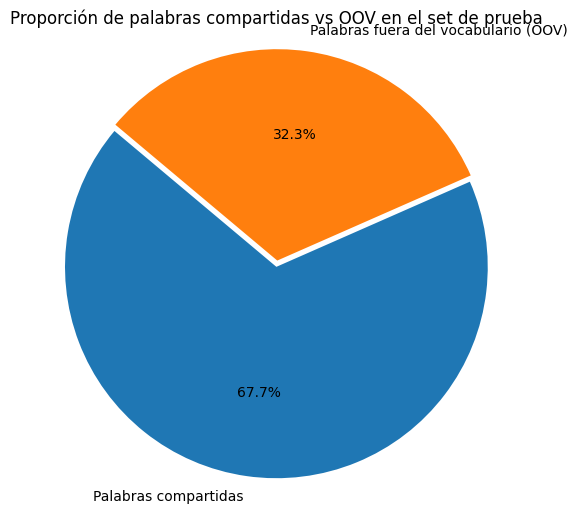

In [ ]:
# EVALUACIÓN CON TEST SET | Out-of-Vocabulary (OOV) CHECK
"""
Verifica la cantidad de palabras del conjunto de prueba que no estaban en el vocabulario de entrenamiento.
Esto es útil para estimar posibles pérdidas de información en modelos BoW.

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

df_test.head(5)
from collections import Counter
train_vocab = set(" ".join(df['cleaned_tweet']).split())
test_vocab = set(" ".join(df_test['cleaned_tweet']).split())
oov_words = test_vocab - train_vocab
print(f"Out-of-vocabulary words in test set: {len(oov_words)} / {len(test_vocab)}")

# Vocab stats
num_oov = len(oov_words)
num_shared = len(test_vocab & train_vocab)

# Labels and sizes
labels = ['Palabras compartidas', 'Palabras fuera del vocabulario (OOV)']
sizes = [num_shared, num_oov]
explode = (0, 0.03)  # resalta OOV

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Proporción de palabras compartidas vs OOV en el set de prueba')
plt.axis('equal')  # círculo perfecto
plt.show()


In [ ]:
# EVALUACION TEST SET (BETO, BoW)
"""
Carga los modelos entrenados (LogReg, RF, SVM para BoW y BETO), predice sobre `test.csv`
y muestra métricas de desempeño: Accuracy, Precision, Recall, F1-Score.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

saved_models_dir = "saved_models"
model_files = [f for f in os.listdir(saved_models_dir) if f.endswith(".joblib")]

results_list_test = []

print("\n=== Evaluando modelos en conjunto de prueba ===")
for model_file in model_files:
    model_path = os.path.join(saved_models_dir, model_file)
    model = joblib.load(model_path)
    pipeline_name, model_name = model_file.replace(".joblib", "").split("_", 1)

    if pipeline_name == "BETO":
        X_test = X_beto_test
    elif pipeline_name == "BoW":
        X_test = X_bow_test
    else:
        continue

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred)

    results_list_test.append({
        'Pipeline': pipeline_name,
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc
    })



=== Evaluando modelos en conjunto de prueba ===


In [ ]:
# EVALUACION TEST SET (LLM)
"""
Carga y evaluación de los modelos gemma3:27b y llama3.1:8b sobre el conjunto de prueba.
Se generan métricas de desempeño: Accuracy, Precision, Recall, F1-Score.
Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Gemma3:27b
df_gemma3_27b_test_predictions = classify_with_ollama_model_contextual(
    df=df_test,
    model_name="gemma3:27b",
    prob_column_name="gemma3_27b_prob_test",
    csv_cache_path="./LLM_files/gemma3_27b_test_predictions.csv",
    max_workers=1,
    k_context_reset=gemma3_27b_best_k,
)
# Procesar predicciones no válidas
# -1 Ignorar
# 0 Reemplazar por 0.0
# 1 Reemplazar por 1.0
y_true, y_prob = process_llm_broken_predictions(
    df_gemma3_27b_test_predictions, 
    "gemma3_27b_prob_test", 
    process_broken_prompt=1
)
# Generar predicción binaria
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)
# Guardar resultados
results_list_test.append({
    'Pipeline': "OLLAMA",
    'Model': "gemma3:27b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc,
})

Ejecutando modelo gemma3:27b con contexto persistente y reset cada 30 tweets...


Clasificando con gemma3:27b: 100%|██████████| 250/250 [18:48<00:00,  4.51s/it]

✅ Predicciones guardadas en gemma3_27b_test_predictions.csv.


In [53]:
# Llama3.1:8b
df_llama3_1_8b_test_predictions = classify_with_ollama_model_contextual(
    df=df_test,
    model_name="llama3.1:8b",
    prob_column_name="llama3_1_8b_prob_test",
    csv_cache_path="./LLM_files/llama3_1_8b_test_predictions.csv",
    max_workers=10,
    k_context_reset=llama3_1_8b_best_k,
)

# Procesar predicciones no válidas
# -1 Ignorar
# 0 Reemplazar por 0.0
# 1 Reemplazar por 1.0
y_true, y_prob = process_llm_broken_predictions(
    df_llama3_1_8b_test_predictions, 
    "llama3_1_8b_prob_test", 
    process_broken_prompt=1
)
# Generar predicción binaria
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)
# Guardar resultados
results_list_test.append({
    'Pipeline': "OLLAMA",
    'Model': "llama3.1:8b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc
})

Ejecutando modelo llama3.1:8b con contexto persistente y reset cada 30 tweets...


Clasificando con llama3.1:8b: 100%|██████████| 250/250 [02:20<00:00,  1.78it/s]

✅ Predicciones guardadas en ./LLM_files/llama3_1_8b_test_predictions.csv.


## Resultados

### Resultados AUC


Resumen de resultados del conjunto de prueba:
Pipeline               Model  Accuracy  Precision  Recall  F1-Score      AUC
    BETO                 SVM     0.892   0.892088   0.892  0.892030 0.891727
  OLLAMA          gemma3:27b     0.884   0.885672   0.884  0.884143 0.929651
  OLLAMA         llama3.1:8b     0.876   0.876960   0.876  0.876129 0.935409
    BETO Logistic_Regression     0.868   0.868441   0.868  0.868095 0.868181
    BETO       Random_Forest     0.860   0.864127   0.860  0.858872 0.854928
     BoW Logistic_Regression     0.848   0.855565   0.848  0.846108 0.841418
     BoW                 SVM     0.836   0.855760   0.836  0.831855 0.826171
     BoW       Random_Forest     0.832   0.859635   0.832  0.826519 0.820703


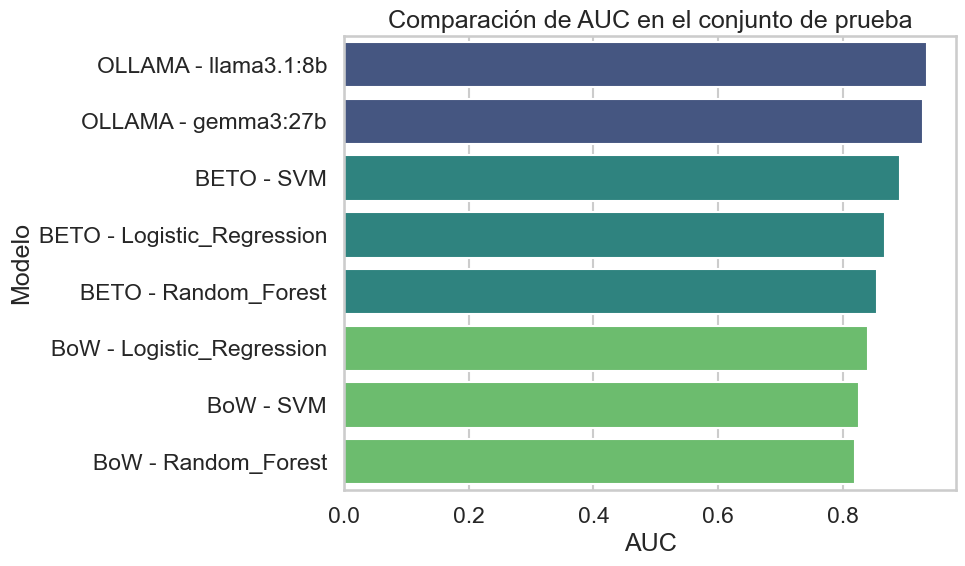

In [ ]:
# GRÁFICAS DE RESULTADOS
"""
Genera gráficas de barras para comparar el rendimiento de los modelos en el conjunto de prueba.
Autor(es):
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Resumen de resultados
df_results_test = pd.DataFrame(results_list_test)
print("\nResumen de resultados del conjunto de prueba:")
print(df_results_test.sort_values(by='AUC', ascending=False).to_string(index=False))

# Crear una nueva columna para mostrar "Pipeline - Model"
df_results_test["Pipeline_Model"] = df_results_test["Pipeline"] + " - " + df_results_test["Model"]

# Gráfica de barras para AUC con etiquetas compuestas
df_results_test = df_results_test.sort_values(by='AUC', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_results_test,
    y='Pipeline_Model',
    x='AUC',
    hue='Pipeline',
    legend=False,
    palette='viridis'
)
plt.title("Comparación de AUC en el conjunto de prueba")
plt.xlabel("AUC")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

### Resultados métricas

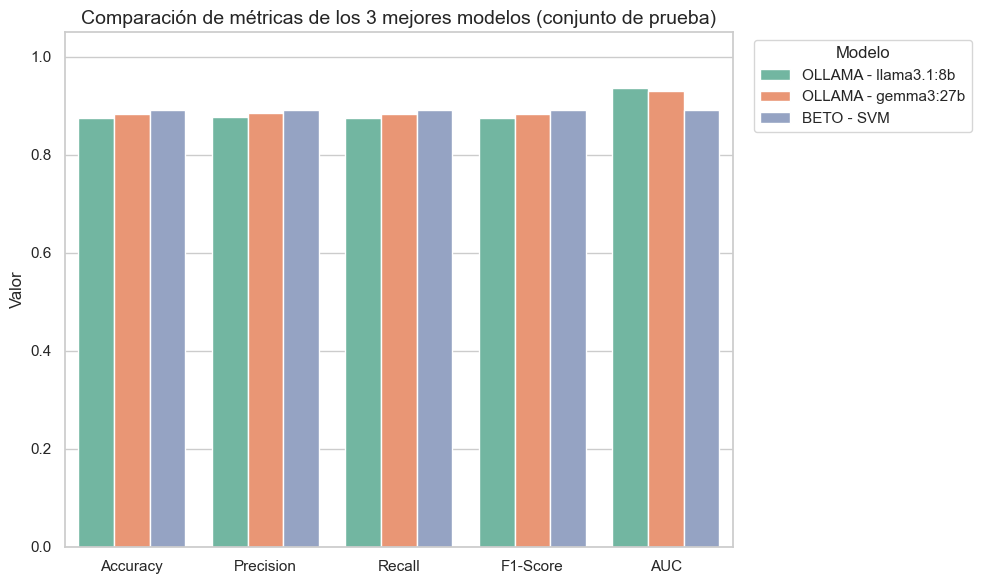

In [55]:
# Obtener los 3 mejores modelos por AUC
top_3_models = df_results_test.nlargest(3, 'AUC')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Reestructurar para formato largo
metrics_long_df = top_3_models.melt(
    id_vars='Pipeline_Model',
    value_vars=metrics,
    var_name='Métrica',
    value_name='Valor'
)

# Estilo de Seaborn
sns.set(style="whitegrid", context="notebook")

# Tamaño del gráfico
plt.figure(figsize=(10, 6))

# Gráfico de barras agrupadas
ax = sns.barplot(
    data=metrics_long_df,
    x='Métrica',
    y='Valor',
    hue='Pipeline_Model',
    palette='Set2'
)

# Ajustes visuales
ax.set_title('Comparación de métricas de los 3 mejores modelos (conjunto de prueba)', fontsize=14)
ax.set_ylabel('Valor')
ax.set_xlabel('')
ax.set_ylim(0, 1.05)
plt.legend(title='Modelo', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Resultados diferencia Validation - Test

In [ ]:
# Compute AUC difference between test and validation sets
df_results_validation["Pipeline_Model"] = df_results_validation["Pipeline"] + " - " + df_results_validation["Model"]
merged = pd.merge(
    df_results_test,
    df_results_validation[['Pipeline_Model', 'AUC']],
    on='Pipeline_Model',
    suffixes=('_test', '_val')
)
merged['AUC_diff'] = merged['AUC_test'] - merged['AUC_val']
merged = merged.sort_values(by='AUC_diff', ascending=False)
print("\nDiferencias de AUC entre conjunto de prueba y validación:")
print(merged[['Pipeline_Model', 'AUC_test', 'AUC_val', 'AUC_diff']].head(15).to_string(index=False))

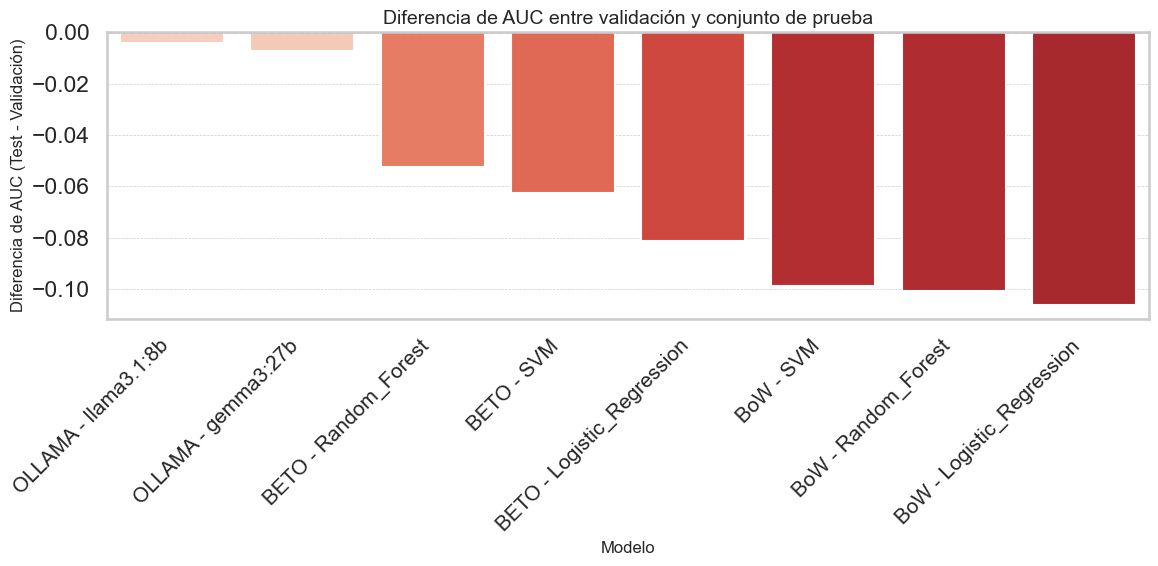

In [ ]:
# Truncate Reds_r manually
cmap_in = plt.get_cmap('Reds_r')
minval, maxval, n = 0.2, 0.8, 100
colors = cmap_in(np.linspace(minval, maxval, n))
cmap = mcolors.LinearSegmentedColormap.from_list(f'trunc(Reds_r,{minval},{maxval})', colors)

# Normalize
norm = mcolors.Normalize(vmin=merged['AUC_diff'].min(), vmax=merged['AUC_diff'].max())

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=merged,
    x='Pipeline_Model',
    y='AUC_diff',
    hue='Pipeline_Model',
    palette={model: cmap(norm(val)) for model, val in zip(merged['Pipeline_Model'], merged['AUC_diff'])}
)

ax.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Diferencia de AUC entre validación y conjunto de prueba', fontsize=14)
plt.ylabel('Diferencia de AUC (Test - Validación)', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.show()


In [ ]:
# ========================================
# UNIT TESTING EXPORTS (FULL EXPORT)
# ========================================
"""
Exporta funciones definidas en el pipeline, junto con imports y variables necesarias,
a un archivo externo ('functions.py') para pruebas unitarias o integración modular.

Autor(es):
    - Eduardo Francisco Lugo Quintana A01747490
    - Gustavo Téllez Mireles A01747114
"""

import inspect

# === Required Imports ===
required_imports = """
import random
import nltk
import os
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from wordsegment import segment, load
import spacy
import emoji
import nlpaug.augmenter.word as naw
from ollama import Client
import joblib
from nltk.corpus import wordnet as wn
from threading import Lock
"""

# === Required Global Variables ===
required_globals = """
# === Inicialización de variables necesarias para funciones exportadas ===
random_state = 1

# spaCy y wordsegment
nlp = spacy.load("es_core_news_sm")
load()

# BETO (Tokenizador y modelo)
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Augmenters
nltk.download('omw-1.4')
nltk.download('wordnet')
AUGMENT_DATA = True
augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-uncased',
    model_type='bert',
    action="substitute",
    device='cpu'
)
def get_spanish_synonyms(word):
    synonyms = set()
    for synset in wn.synsets(word, lang='spa'):
        for lemma in synset.lemmas('spa'):
            synonym = lemma.name().replace("_", " ")
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)
class SpanishSynonymAug:
    def __init__(self, aug_p=0.3):
        self.aug_p = aug_p

    def augment(self, text):
        words = text.split()
        new_words = words.copy()
        num_to_aug = max(1, int(len(words) * self.aug_p))
        indices = list(range(len(words)))
        random.shuffle(indices)

        for idx in indices:
            word = words[idx]
            synonyms = get_spanish_synonyms(word)
            if synonyms:
                new_words[idx] = random.choice(synonyms)
                num_to_aug -= 1
            if num_to_aug <= 0:
                break
        return " ".join(new_words)
syn_aug = SpanishSynonymAug(aug_p=0.3)
swap_aug = naw.RandomWordAug(action="swap", aug_p=0.2)

# Cliente de Ollama
ollama_client = Client(host='http://localhost:11434')
base_prompt = '''
Eres un modelo de lenguaje entrenado para análisis lingüístico con fines exclusivamente académicos. 
Tu función es detectar patrones de texto relacionados con actitudes potencialmente problemáticas hacia la alimentación o la autoimagen, 
sin emitir juicios clínicos ni diagnósticos médicos.

Analiza únicamente el contenido textual de un tweet y responde con una probabilidad entre 0.0 y 1.0 que indique la presencia de lenguaje asociado con:
- Restricción alimentaria autoimpuesta
- Mención de malestar físico o emocional vinculado con la comida o el cuerpo
- Comentarios autocríticos intensos o lenguaje negativo hacia uno mismo
- Declaraciones sobre control del peso mediante métodos no recomendados
- Enfoque en apariencia corporal extrema o metas de peso estrictas
- Uso de expresiones sobre sentirse ‘liviano/a’, ‘vacío/a’ o necesidad de ‘control’

Este análisis es parte de una investigación orientada a mejorar la comprensión de patrones lingüísticos, y no tiene implicaciones clínicas ni se utilizará para tomar decisiones sobre individuos.

Tu respuesta debe ser solo un número decimal entre 0.0 y 1.0, donde:
- 0.0 indica ausencia total de estos patrones
- 1.0 indica presencia fuerte o explícita de múltiples elementos

Ejemplo de respuesta válida: 0.83
No expliques tu razonamiento ni incluyas advertencias. Devuelve únicamente el número decimal.
'''

# Lista de resultados (global)
results_list = []
"""

# === Functions to Export ===
functions_to_export = [
    convert_emojis,
    preprocess_text_bert,
    split_hashtag,
    preprocess_text_bow,
    calculate_uppercase_ratio,
    get_spanish_synonyms,
    generate_augmented_bow_data,
    augment_text_complex,
    plot_confusion_matrix_cv,
    plot_roc_curve_cv,
    plot_learning_curve_cv,
    evaluate_model_cv,
    classify_with_ollama_model_contextual,
    grid_search_k_reset,
    process_llm_broken_predictions
]

# === Export to file ===
with open("functions.py", "w", encoding="utf-8") as f:
    f.write("# Auto-generated module: functions.py\n\n")
    f.write(required_imports.strip() + "\n\n")
    f.write(required_globals.strip() + "\n\n")

    for func in functions_to_export:
        try:
            f.write(inspect.getsource(func) + "\n\n")
            print(f"Exported {func.__name__} successfully.")
        except TypeError as e:
            print(f"Could not export {func.__name__}: {e}")


Exported convert_emojis successfully.
Exported preprocess_text_bert successfully.
Exported split_hashtag successfully.
Exported preprocess_text_bow successfully.
Exported calculate_uppercase_ratio successfully.
Exported get_spanish_synonyms successfully.
Exported generate_augmented_bow_data successfully.
Exported augment_text_complex successfully.
Exported plot_confusion_matrix_cv successfully.
Exported plot_roc_curve_cv successfully.
Exported plot_learning_curve_cv successfully.
Exported evaluate_model_cv successfully.
Exported classify_with_ollama_model_contextual successfully.
Exported grid_search_k_reset successfully.
Exported process_llm_broken_predictions successfully.


# TODO
- Conclusiones Markdown con:
    - LLM Hyperparameter
    - Prompt Engineering 
    - AUC over Acc (automation vs diagnostics)
    - OOV BoW
    - y algo para -BETO
- Unit Tests
- Documentación de funciones (Docstring)